[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


number of parameters: 123.65M
Epoch: 1 loss: 0.030
Epoch: 2 loss: 0.022
Epoch: 3 loss: 0.016
Epoch: 4 loss: 0.012
Epoch: 5 loss: 0.010
Epoch: 6 loss: 0.009
Epoch: 7 loss: 0.008
Epoch: 8 loss: 0.007
Epoch: 9 loss: 0.006
Epoch: 10 loss: 0.006
Finished Training
              precision    recall  f1-score   support

     class 0       0.82      0.90      0.86        10
     class 1       0.73      0.80      0.76        10
     class 2       0.88      0.70      0.78        10

    accuracy                           0.80        30
   macro avg       0.81      0.80      0.80        30
weighted avg       0.81      0.80      0.80        30



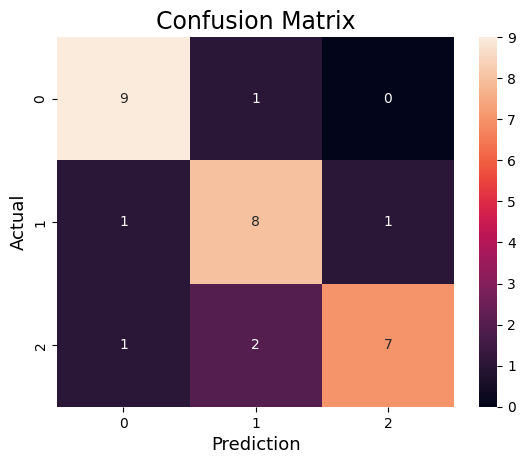

In [2]:
def train_model():
  # FINETUNE GPT2 

  #-----------------------------------
  # Parameters:
  # init_from = 'gpt2 
  # batch_size = 12
  # gradient_accumulation_steps = 32
  # max_iters = 300
  # block_size = 128
  # learning_rate = 3e-5
  # decay_lr = False
  #-----------------------------------

  !python train.py /content/config/finetune_customer_service.py --compile=False



def load_model():
  #-------------------------------------------------------------------------------------------
  # MODEL LOAD

  import os
  import torch
  from model import GPTConfig, GPT

  out_dir = "/content/out-gpt2-customer-service"
  device = 'cuda'


  ckpt_path = os.path.join(out_dir, 'ckpt.pt')
  checkpoint = torch.load(ckpt_path, map_location=device)
  gptconf = GPTConfig(**checkpoint['model_args'])
  model = GPT(gptconf).to(device)
  state_dict = checkpoint['model']
  model.load_state_dict(state_dict)

  return model

def main():

  import nltk
  import os
  import pickle
  from contextlib import nullcontext
  import torch
  import tiktoken
  from model import GPTConfig, GPT
  import numpy as np
  from imblearn.over_sampling import RandomOverSampler, SMOTE
  from imblearn.under_sampling import RandomUnderSampler
  import torch.nn as nn
  from sklearn.utils import class_weight
  from sklearn.metrics import f1_score
  import torch.optim as optim

  !pip install tiktoken
  nltk.download('stopwords')
  nltk.download('wordnet')

  model = load_model()
  device = 'cuda'

  #-------------------------------------------------------------------------------------------
  # PREPROCESSING

  def preprocessing(df):
    import tiktoken
    import nltk
    import string
    from nltk.stem import WordNetLemmatizer
    from nltk.corpus import RegexpTokenizer, stopwords

    # Sentiment Mapping
    sentiment_dict = {'negative':0,'neutral':1,'positive':2}
    df["customer_sentiment"]=df["customer_sentiment"].map(sentiment_dict)
    df = df.loc[:,["customer_sentiment","conversation"]].copy()

    # Remove Punctuation
    def remove_punctuation(text):
        no_punct = "".join([c for c in text if c not in string.punctuation])
        return no_punct

    # Remove Stopwords
    def remove_stopwords(text):
        words = [w for w in text if w not in stopwords.words('english')]
        return words

    # Lemmatization
    def word_lemmatizer(text):
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(x) for x in text]

    # Remove numbers
    def remove_numbers(text):
        return [x for x in text if not x.isdigit()]

    df["conversation"] = df["conversation"].apply(lambda x: remove_punctuation(x))
    # Tokenize the text
    tokenizer = RegexpTokenizer(r'\w+')
    df["conversation"] = df["conversation"].apply(lambda x: tokenizer.tokenize(x.lower()))
    df["conversation"] = df["conversation"].apply(lambda x: remove_stopwords(x))
    df["conversation"] = df["conversation"].apply(lambda x: word_lemmatizer(x))
    df["conversation"] = df["conversation"].apply(lambda x: remove_numbers(x))

    df["conversation"] = df["conversation"].apply(lambda x: " ".join(x))

    enc = tiktoken.get_encoding("gpt2")
    df["conversation"] = df["conversation"].apply(lambda x: enc.encode(x))
    return df

    # Crop sequences around middle
  def crop(seq,seq_len):
    return seq[len(seq)//2 - seq_len//2:len(seq)//2 + seq_len//2]


  #-------------------------------------------------------------------------------------------
  # LOAD and PREPROCESS 

  import pandas as pd
  path = "/content/data/customer_service"
  df_train= pd.read_csv(path +'/train.csv')
  df_test= pd.read_csv(path +'/test.csv')

  df_train = preprocessing(df_train)
  df_test = preprocessing(df_test)

  # Only have the samples greater than length 128
  df_train = df_train.loc[df_train["conversation"].apply(len)>128].copy()

  # To make every sequence have the same length, crop from middle 
  df_train["conversation"] = df_train["conversation"].apply(lambda x: crop(x,128))

  # Train variables
  X_train = df_train.drop(columns=["customer_sentiment"])
  y_train = df_train["customer_sentiment"]

  # Undersampling and Oversampling
  sampling_strategy_over ={2:200}
  sampling_strategy_under ={0:300, 1:300}
  oversampler = RandomOverSampler(sampling_strategy=sampling_strategy_over,random_state= 42)
  undersampler = RandomUnderSampler(sampling_strategy=sampling_strategy_under,random_state= 42)
  X_train_over, y_train_over = oversampler.fit_resample(X_train, y_train)
  X_train_sampled, y_train_sampled = undersampler.fit_resample(X_train_over, y_train_over)

  # One last shuffle before training
  df_temp=pd.DataFrame(zip(X_train_sampled['conversation'],y_train_sampled))
  df_finalized = df_temp.sample(frac=1).reset_index(drop=True)
  #-------------------------------------------------------------------------------------------
  # CLASSIFICATION HEAD

  class Classifier(nn.Module):
      def __init__(self,hidden_dim,hidden_dim_2):
          super(Classifier,self).__init__()
          self.fc_1   = nn.Linear(768,hidden_dim)
          self.relu    = nn.ReLU()
          self.fc_2   = nn.Linear(hidden_dim,hidden_dim_2)
          self.proj  = nn.Linear(hidden_dim_2, 3)

      def forward(self, x):
          x = self.fc_1(x)
          x = self.relu(x)
          x = self.fc_2(x)
          x = self.relu(x)
          x = self.proj(x)
          return x

  hidden_dim = 384
  hidden_dim2 = 48
  clss = Classifier(hidden_dim, hidden_dim2).to(device)
  #-------------------------------------------------------------------------------------------
  # LOSS FUNCTION and OPTIMIZER

  # Weights for Cross Entropy
  class_weights=class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_train_sampled), y=y_train_sampled)
  cw = torch.tensor(class_weights, dtype= torch.float32).to(device)

  # Define loss, optimizer and the batch size
  criterion = nn.CrossEntropyLoss(weight = cw )
  optimizer = optim.Adam(clss.parameters(), lr=0.001)
  batch_size = 32

  clss.train()
  model.eval()
  best_loss = float('inf')
  #-------------------------------------------------------------------------------------------
  # TRAINING LOOP

  epochs = 10
  for epoch in range(epochs):  # loop over the dataset multiple time
      running_loss = 0.0
      for i in range(0,len(df_finalized),batch_size):

          # get the inputs; data is a list of [inputs, labels]
          ids = df_finalized.iloc[i:i+batch_size,0].reset_index(drop=True)
          labels = torch.tensor(df_finalized.iloc[i:i+batch_size,1].to_numpy(), dtype=torch.long).to(device)

          # forward pass to get embeddings, take the mean of the embeddings and pass to classification head
          inputs = (torch.tensor(ids, dtype=torch.long, device=device)[None, ...])
          _,_,embs=model(inputs[0])
          mean_embs = torch.mean(embs, dim = 1)
          outputs = clss(mean_embs)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()

          if running_loss < best_loss:
            torch.save(clss.state_dict(), 'best-model-parameters.pt')

      print(f'Epoch: {epoch + 1} loss: {running_loss/len(X_train):.3f}')


  print('Finished Training')

  #-------------------------------------------------------------------------------------------
  # EVALUATION

  #Load the best model
  best_model = Classifier(hidden_dim, hidden_dim2).to(device)
  best_model.load_state_dict(torch.load('/content/best-model-parameters.pt'))

  # Preprocessing the test set
  X_test = df_test.drop(columns=["customer_sentiment"])
  y_test = df_test["customer_sentiment"]
  X_test["conversation"]=X_test["conversation"].apply(lambda x: crop(x,108))

  # Forward pass and prediction for the test set
  best_model.eval()
  ids = X_test["conversation"]
  test_labels = torch.tensor(y_test.to_numpy()).to(device)

  inputs = (torch.tensor(ids, dtype=torch.long, device=device)[None, ...])
  _,_,embs=model(inputs[0])
  mean_embs = torch.mean(embs, dim =1)
  outputs = best_model(mean_embs)
  preds =  torch.argmax(outputs.data, 1)

  y_true = test_labels.cpu()
  y_pred = preds.cpu()

  # Classification Report
  target_names = ['class 0', 'class 1', 'class 2']

  from sklearn.metrics import classification_report
  print(classification_report(y_true, y_pred, target_names=target_names))

  # Confusion Matrix Report
  from sklearn.metrics import confusion_matrix
  import seaborn as sns
  import matplotlib.pyplot as plt

  cm = confusion_matrix(y_true,y_pred)
  sns.heatmap(cm,
                annot=True,
                fmt='g',
                xticklabels=['0','1','2'],
                yticklabels=['0','1','2'])

  plt.xlabel('Prediction',fontsize=13)
  plt.ylabel('Actual',fontsize=13)
  plt.title('Confusion Matrix',fontsize=17)
  plt.show()

main()